#### Imports

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#### Loading the datasets

In [ ]:
pd.set_option('expand_frame_repr', False) # for displaying dataframe in single line
datasets = [pd.read_csv(i) for i in [f"https://raw.githubusercontent.com/jsmaskeen/datasets/main/{j}.csv" for j in range(2000,2024)]]
for i in datasets:
  i['date'] = pd.to_datetime(i['date'])
def df(year):
  return datasets[year-2000]

alldf = pd.concat(datasets)
alldf.sort_values('date',inplace=True)
player_dataset = pd.read_csv("https://raw.githubusercontent.com/jsmaskeen/datasets/main/atp_players.csv")

Omitting the 2024 dataset as it is not yet complete

## ES114 Lab 10 Data Narrative
### Jaskirat Singh Maskeen - 23110146

### Q1. On which surface it is hardest to win ?

Win probabilites of players on a specific surface.
         Win probability mean  Standard Deviation
surface                                          
Hard                 0.394580            0.148374
Clay                 0.406061            0.141221
Grass                0.430056            0.156142
Carpet               0.464116            0.148930

This shows that the easiest surface to play on is "Carpet" while the hardest surface is "Hard"

Comparing the "Carpet" and "Hard" surface on one plot witha fitted gaussian curve.


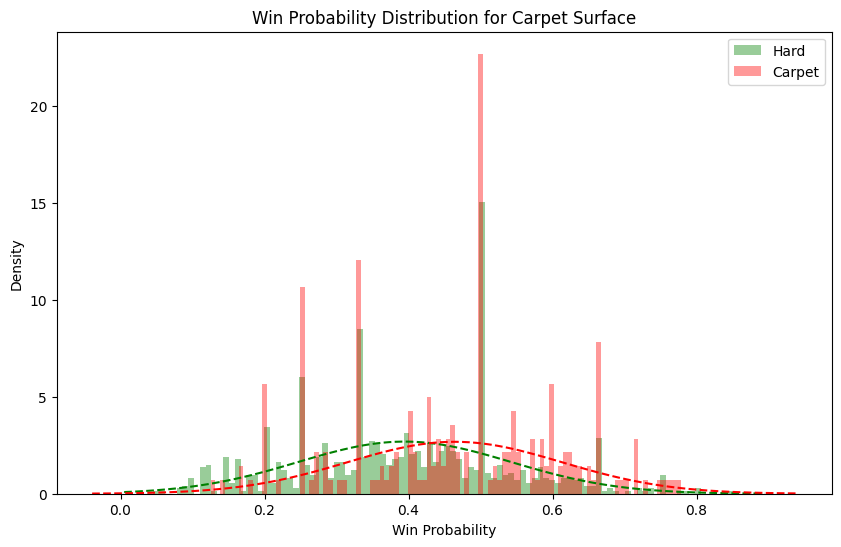

In [ ]:
surface_wins = alldf.groupby(['winner', 'surface']).size().reset_index(name='wins')
surface_losses = alldf.groupby(['loser', 'surface']).size().reset_index(name='losses')
surface_stats = pd.merge(surface_wins, surface_losses, left_on=['winner', 'surface'], right_on=['loser', 'surface'], how='outer').dropna()#.fillna(0)

surface_stats['total'] = surface_stats['wins'] + surface_stats['losses']
surface_stats['win_prob'] = surface_stats['wins'] / surface_stats['total']
print("Win probabilites of players on a specific surface.")
surface_stats= surface_stats[['winner', 'surface', 'win_prob']].sort_values('win_prob',ascending=False)
mean = surface_stats.groupby('surface')['win_prob'].mean()
std = surface_stats.groupby('surface')['win_prob'].std()
a = pd.DataFrame({
    'Win probability mean':mean,
    'Standard Deviation':std
})
a=a.sort_values('Win probability mean')
print(a)
print()
print('This shows that the easiest surface to play on is "Carpet" while the hardest surface is "Hard"')
print()
print('Comparing the "Carpet" and "Hard" surface on one plot witha fitted gaussian curve.')
def gaussian_pdf(x,mean,variance):
  return np.exp(-(x-mean)**2/(2*variance))/np.sqrt(2*np.pi*variance)

surfaces = surface_stats['surface'].unique()
surface_data = {"Hard": surface_stats[surface_stats['surface'] == "Hard"]['win_prob'],
                "Carpet": surface_stats[surface_stats['surface'] == "Carpet"]['win_prob'],
}
colors = {
    "Hard":"green",
    "Carpet":"red"
}
plt.figure(figsize=(10,6))
for surface, win_probs in surface_data.items():
    plt.hist(win_probs, bins=100, density=True,color=colors[surface] ,alpha=0.4,label=surface)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = [gaussian_pdf(i,win_probs.mean(),win_probs.var()) for i in x]
    plt.plot(x, p, '--',color=colors[surface] )

plt.title(f'Win Probability Distribution for {surface} Surface')
plt.xlabel('Win Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

### Q2. What is the probability of winning, given higher Bet365W odds ?

In [ ]:
alldf2 = alldf.dropna(subset=['b365w', 'b365l'])
higherb365w = alldf2[alldf2['b365w'] > alldf2['b365l']]
totalb365w = len(higherb365w)
total_matches = len(alldf2)
ans = totalb365w / total_matches
print(f"Probability of winning the match given higher Bet365W odds: {ans}")

Probability of winning the match given higher Bet365W odds: 0.29274733224814614


### Q3. For matches with five sets, what is the probability that a player who has won first two sets, eventually wins the match ?


In [ ]:
wins2set = alldf[(alldf['wsets'] == 2) & (alldf['lsets'] == 0) & (alldf['best_of'] == 5) & ( alldf['comment'] == 'Completed')]
matches_withwin2set = alldf[(alldf['wsets'] == 2) & (alldf['best_of'] == 5)& (alldf['comment'] == 'Completed')]
print(f'Probability of winning the five set match given the player won first two sets = {len(wins2set)/len(matches_withwin2set)}')

Probability of winning the five set match given the player won first two sets = 0.6666666666666666


### Q4. What are the number of tournaments in all series since 2000?

                    tournament
series                        
ATP250                     131
ATP500                      29
Grand Slam                   4
International              102
International Gold          22
Masters                     20
Masters 1000                12
Masters Cup                  1



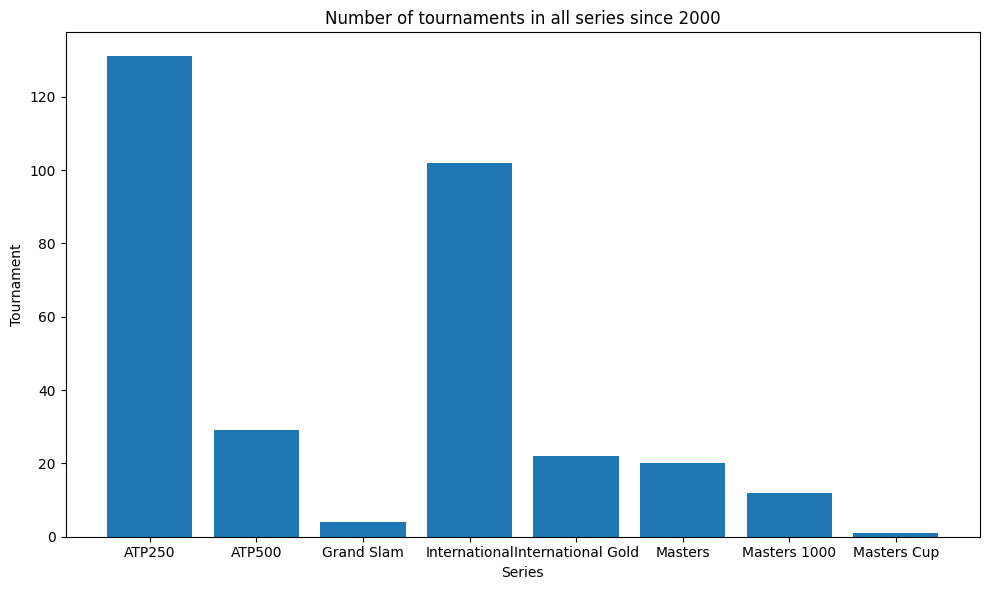

In [ ]:
x = alldf[['tournament','series']].drop_duplicates().groupby('series').count()
print(x)
print()
plt.figure(figsize=(10,6))
plt.bar(x.index,x.to_numpy()[:,0])
plt.xlabel('Series')
plt.ylabel('Tournament')
plt.title('Number of tournaments in all series since 2000')
plt.tight_layout()
plt.show()

### Q5. Is there any relation between player's winrate and his height or weight ?

Correlation Matrix
['height_cm', 'winrate', 'weight_kg']
[[1.         0.1229035  0.74229449]
 [0.1229035  1.         0.12486298]
 [0.74229449 0.12486298 1.        ]]

This indicates that there is an almost equal correlation between win rate and player weight, and win rate and player height
Moreover, this indicates that height and weight affect win rate equally, and also that height and weight are positively correlated.



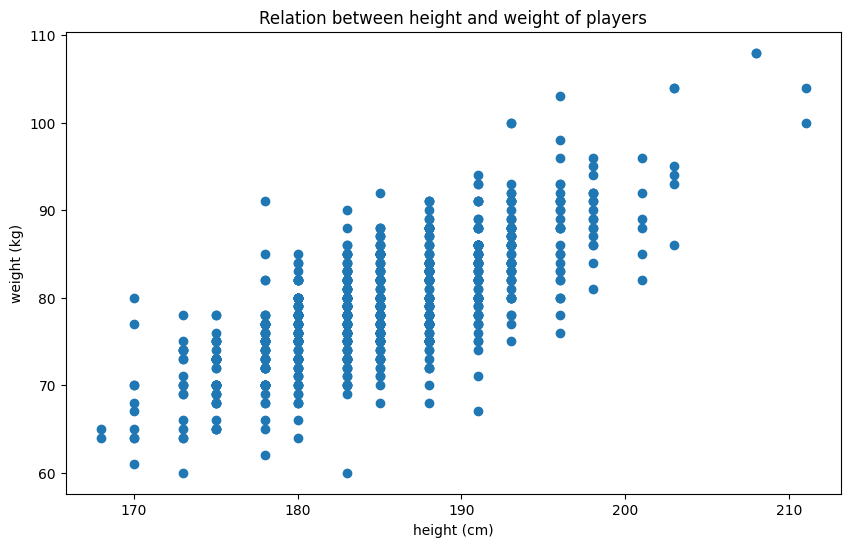

In [ ]:
def cov_corcoef(c1,c2):
  n = len(c1)
  m1 = np.mean(c1)
  v1 = np.sum((c1-m1)**2)/(n-1)
  m2 = np.mean(c2)
  v2 = np.sum((c2-m2)**2)/(n-1)
  cov = np.dot((c1-m1),(c2-m2))/(n-1)
  corcoef = cov/np.sqrt(v1*v2)
  return cov,corcoef

players_wins = alldf['winner'].value_counts()
players_matches = pd.concat([alldf['winner'], alldf['loser']]).value_counts()
players_winrate = (players_wins / players_matches).dropna()
tmp = players_winrate.index
g = []
for i in tmp:
  g.append(i.strip()[:-1])
players_winrate.index=g
f = []
for i in range(len(g)):
  f.append([g[i], players_winrate.values[i]])

players_winrate_df = player_dataset.merge(pd.DataFrame(f,columns=['name','winrate']), left_on='full_name', right_on='name')

yy = players_winrate_df[['height_cm', 'winrate','weight_kg']].dropna()
c1,c2,c3 = yy['height_cm'].to_numpy(),yy['winrate'].to_numpy(),yy['weight_kg'].to_numpy()
c1,c2,c3 = list(c1),list(c2),list(c3)
c2.pop(c1.index(0))
c3.pop(c1.index(0))
c1.pop(c1.index(0))
c2.pop(c1.index(0))
c3.pop(c1.index(0))
c1.pop(c1.index(0))
cc = [c1,c2,c3]
attributes = ['height_cm', 'winrate','weight_kg']
corr_matrix = np.zeros((len(attributes),len(attributes)))
for i in range(len(attributes)):
  for j in range(len(attributes)):
    corr_matrix[i,j] = cov_corcoef(cc[i],cc[j])[1]
print('Correlation Matrix')
print(attributes)

print(corr_matrix)
print()
print('This indicates that there is an almost equal correlation between win rate and player weight, and win rate and player height')
print('Moreover, this indicates that height and weight affect win rate equally, and also that height and weight are positively correlated.')
print()
plt.figure(figsize=(10,6))
plt.scatter(c1,c3)
plt.xlabel('height (cm)')
plt.ylabel('weight (kg)')
plt.title('Relation between height and weight of players')
plt.show()

### Q6. What are the number of matches in seasons depending on surface type ?

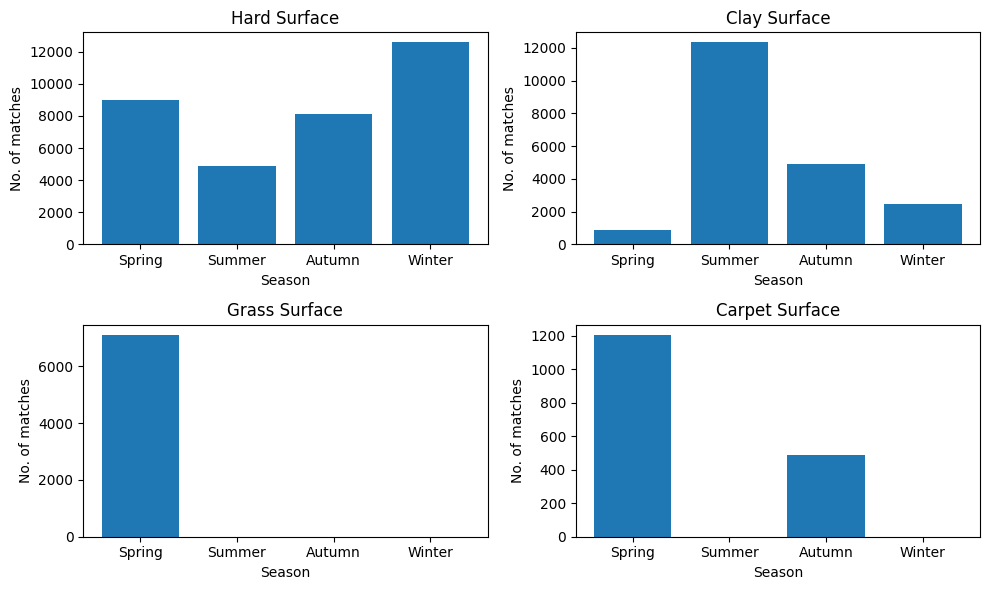


This shows grass surface is only used during spring season, and carpet surface is used for both spring and autumn.
Whereas, hard surface and clay surface are used throughout the year


In [ ]:
seasons = ['Spring','Summer','Autumn','Winter']
def get_season(month):
  if 3<=month and month <=5:
    return 'Spring'
  elif 6<=month and month<=8:
    return 'Summer'
  elif 9<=month and month <= 10:
    return 'Autumn'
  else:
    return 'Winter'
y = alldf.copy()
y['season'] = y['date'].apply(lambda x:get_season(x.month))
surfaces = y['surface'].unique()
plt.figure(figsize=(10,6))
for idx,surface in enumerate(surfaces):
  plt.subplot(2,2,1+idx)
  d = y[y['surface']==surface][['tournament','season']].groupby('season').count().values[:,0]
  ss = {}
  for i in range(4):
    try:
      ss[seasons[i]] = d[i]
    except IndexError:
      ss[seasons[i]] =0

  plt.bar(ss.keys(),ss.values())
  print()
  plt.xlabel('Season')
  plt.ylabel('No. of matches')
  plt.title(f'{surface} Surface')

plt.tight_layout()
plt.show()
print()
print('This shows grass surface is only used during spring season, and carpet surface is used for both spring and autumn.\nWhereas, hard surface and clay surface are used throughout the year')


### Q7. How correlated are the Bet365L odds and AvgL odds ?

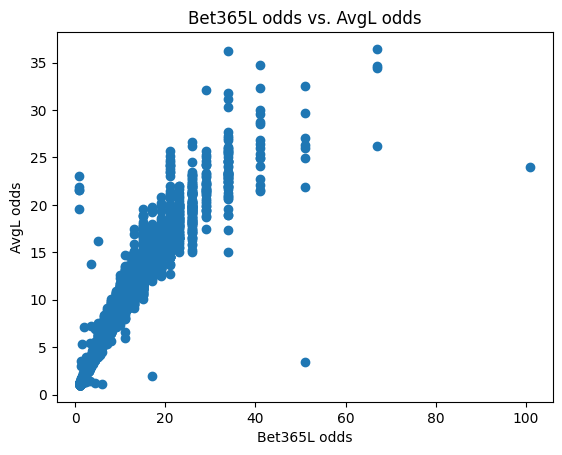


Correlation coefficient between Bet365L odds and AvgL odds = 0.9658305349686895

This shows that Bet365 odds for match loser are highly correlated with Avg odds for match loser.


In [ ]:
def cov_corcoef(c1,c2):
  n = len(c1)
  m1 = np.mean(c1)
  v1 = np.sum((c1-m1)**2)/(n-1)
  m2 = np.mean(c2)
  v2 = np.sum((c2-m2)**2)/(n-1)
  cov = np.dot((c1-m1),(c2-m2))/(n-1)
  corcoef = cov/np.sqrt(v1*v2)
  return cov,corcoef

y = alldf.copy()
y.dropna(subset=['b365w', 'b365l',
       'avgw', 'avgl'],inplace=True)

plt.scatter(y['b365l'],y['avgl'])
plt.xlabel('Bet365L odds')
plt.ylabel('AvgL odds')
plt.title('Bet365L odds vs. AvgL odds')
plt.show()
print()
print(f"Correlation coefficient between Bet365L odds and AvgL odds = {cov_corcoef(y['b365l'].to_numpy(),y['avgl'].to_numpy())[1]}")
print()
print('This shows that Bet365 odds for match loser are highly correlated with Avg odds for match loser.')

### Q8. Find the number of Grand Slam matches won at different ages. Hence find the most successful player in Grand Slams.

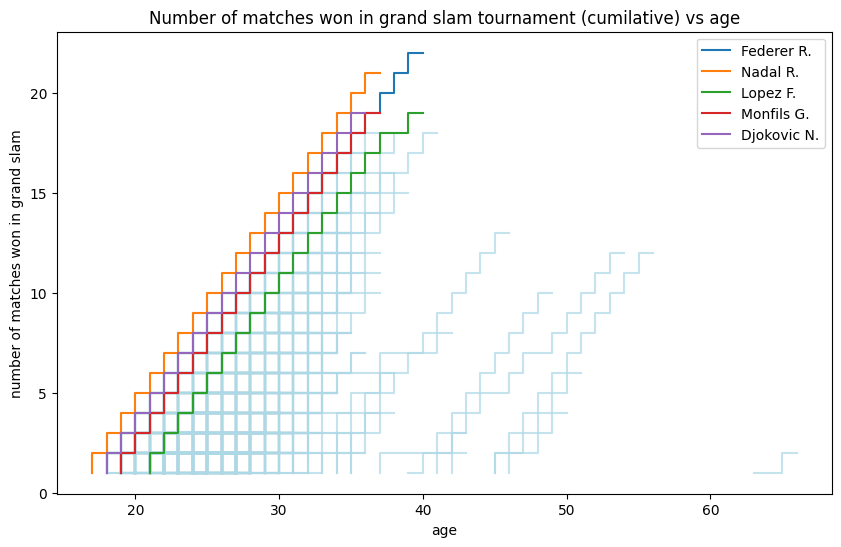


The most successful player is Federer R. with 22 wins at grand slam matches.


In [ ]:
df2 = alldf[(alldf['series'] == 'Grand Slam') ].copy() #& (alldf['round']=='The Final')
df2['year'] = df2['date'].apply(lambda x:x.year)
winners = list(df2['winner'].unique())
def get_age(pname,year):
  by = player_dataset[player_dataset['full_name'] + '.' == pname]['birth_year'].to_numpy()
  if len(by) == 0:
    return np.nan
  return year - by[0]

l = []

for winner in winners:
  slams = df2[df2['winner'] == winner]['year'].to_numpy()
  yrange = list(range(min(slams),max(slams)+1))
  sl = []
  for i in yrange:
    if i in slams:
      sl.append(1)
    else:
      sl.append(0)
  ages = [get_age(winner,i) for i in yrange]
  if np.isnan(ages[0]):
    continue
  l.append({
      'player':winner,
      'ages':ages,
      'slams':sl,
      'cumsum':np.cumsum(sl)
})
l.sort(key=lambda x:x['cumsum'][-1] ,reverse=True)
plt.figure(figsize=(10,6))
for i in l[5:]:
  plt.step(i['ages'],np.cumsum(i['slams']),alpha=0.7,color='lightblue')
for i in l[:5]:
  plt.step(i['ages'],np.cumsum(i['slams']),label=i['player'])
plt.legend()
plt.xlabel('age')
plt.ylabel('number of matches won in grand slam')
plt.title('Number of matches won in grand slam tournament (cumilative) vs age')
plt.show()
print()
print(f'The most successful player is {l[0]["player"]} with {l[0]["cumsum"][-1]} wins at grand slam matches.')

### Q9. Who are the most succesful players on various surfaces ?

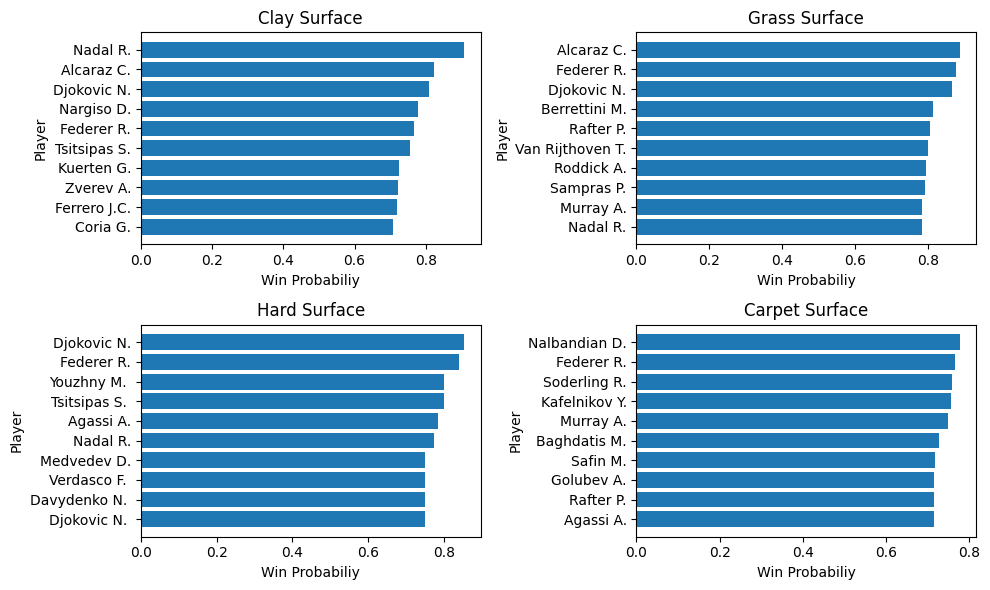

In [ ]:
surface_wins = alldf.groupby(['winner', 'surface']).size().reset_index(name='wins')
surface_losses = alldf.groupby(['loser', 'surface']).size().reset_index(name='losses')
surface_stats = pd.merge(surface_wins, surface_losses, left_on=['winner', 'surface'], right_on=['loser', 'surface'], how='outer').dropna()#.fillna(0)

surface_stats['total'] = surface_stats['wins'] + surface_stats['losses']
surface_stats['win_prob'] = surface_stats['wins'] / surface_stats['total']
surface_stats= surface_stats[['winner', 'surface', 'win_prob']].sort_values('win_prob',ascending=False)
surfaces = surface_stats['surface'].unique()
plt.figure(figsize=(10,6))
ms = []
for idx,s in enumerate(surfaces):
  d = surface_stats[surface_stats['surface']==s][['winner','win_prob']].head(10).to_numpy()
  name,winprob = d[:,0],d[:,1]
  ms.append(name[0])
  plt.subplot(2,2,idx+1)
  plt.barh(name,winprob)
  plt.xlabel('Win Probabiliy')
  plt.ylabel('Player')
  plt.title(f'{s} Surface')
  plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
print()
for i,s in enumerate(surfaces):
  print(f'The most successful player for {s} surface is:\n\t{ms[i]}')

### Q10. What are the number of matches played per round?


The most successful player for Clay surface is:
	Nadal R.
The most successful player for Grass surface is:
	Alcaraz C.
The most successful player for Hard surface is:
	Djokovic N.
The most successful player for Carpet surface is:
	Nalbandian D.


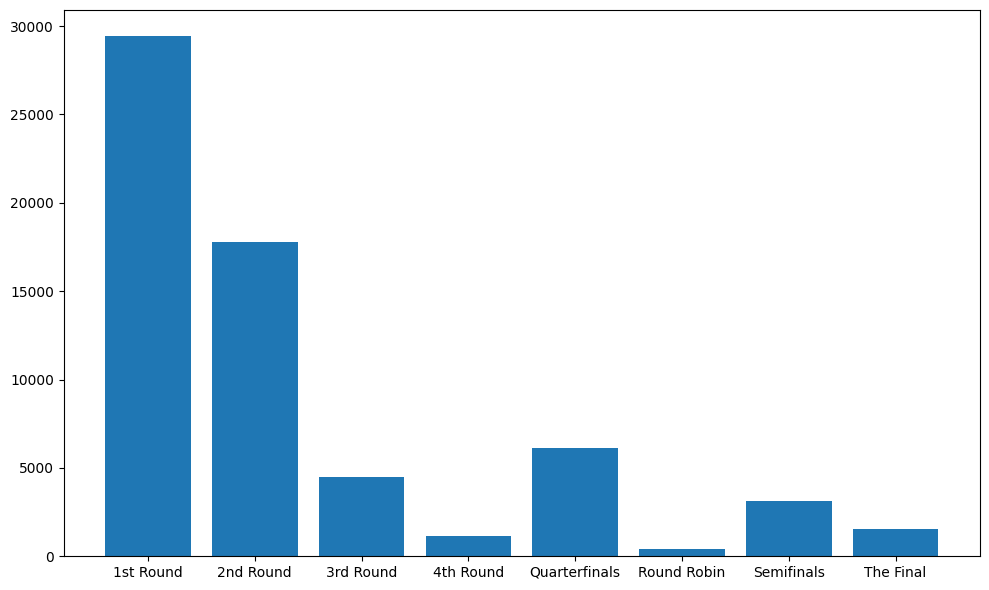


We expect more matches to be in starting rounds, as that would lead to players getting eliminated.
This happens till fourth round, then there is a decrease again from Quarterfinals to The Final

Round robin is an outlier here, because it is used for only two series:
	Masters Cup and International


In [ ]:
x = alldf.groupby('round').count()['tournament']
plt.figure(figsize=(10,6))
plt.bar(x.index,x.to_numpy())
plt.tight_layout()
plt.show()
print()
print('We expect more matches to be in starting rounds, as that would lead to players getting eliminated.\nThis happens till fourth round, then there is a decrease again from Quarterfinals to The Final')
print()
print('Round robin is an outlier here, because it is used for only two series:')
print('\t'+' and '.join(alldf[alldf['round'] == 'Round Robin']['series'].unique()))


### References
- https://stackoverflow.com/questions/34076177/matplotlib-horizontal-bar-chart-barh-is-upside-down
- http://www.tennis-data.co.uk/notes.txt
- https://stackoverflow.com/questions/39482722/how-to-print-dataframe-on-single-line